In [1]:
import numpy as np
from oceanmixedlayers import oceanmixedlayers
import matplotlib.pyplot as plt

import gsw as gsw
import xarray as xr
from glob import glob

%matplotlib inline
%load_ext autoreload
%autoreload 2

def IsVarThere(hndl,VAR):
    CHECK = [A for A in hndl.data_vars  if A==VAR]
    return len(CHECK)>0

In [2]:
# Load in some Argo data for examples of using the omld package

#Some deep ones
#PATH = '/net3/bgr/Datasets/Argo/202011-ArgoData/dac/aoml/3900331/'
#PATH = '/net3/bgr/Datasets/Argo/202011-ArgoData/dac/aoml/3900451/'
PATH = '/net3/bgr/Datasets/Argo/202011-ArgoData/dac/aoml/3900660/'
#Holte and Talley sample
#PATH = '/net3/bgr/Datasets/Argo/202011-ArgoData/dac/aoml/3900621/'


PROFFILE = glob(PATH+'/*_prof.nc')

with xr.open_dataset(PROFFILE[0]) as hndl:

    if ( (IsVarThere(hndl,'TEMP'))&(IsVarThere(hndl,'PSAL'))):
        print('OK')
        NP = hndl.N_PROF.size
        NZ = hndl.N_LEVELS.size
        Z_c_2d       = np.zeros([NP,NZ])+np.NaN
        dZ_2d        = np.zeros([NP,NZ])+np.NaN
        P_c_2d       = np.zeros([NP,NZ])+np.NaN
        dP_2d        = np.zeros([NP,NZ])+np.NaN
        CT_c_2d      = np.zeros([NP,NZ])+np.NaN
        PSal_c_2d    = np.zeros([NP,NZ])+np.NaN
        dRho0dz_c_2d = np.zeros([NP,NZ])+np.NaN
        Rho0_c_2d    = np.zeros([NP,NZ])+np.NaN
        GOOD         = np.zeros([NP],dtype=bool)
        for p in range(NP):
            DayQC = float(hndl.JULD_QC[p])
            PosQC = float(hndl.POSITION_QC[p])
            if (np.max(DayQC==np.array([1,2,5,8]))
                and 
                np.max(PosQC==np.array([1,2,5,8]))):
                
                #QC
                SALTQC = np.array(hndl.PSAL_QC[p,:],dtype=float)
                TEMPQC = np.array(hndl.TEMP_QC[p,:],dtype=float)
                PRESQC = np.array(hndl.PRES_QC[p,:],dtype=float)
                
                #Computes in-situ density from T&S, T, or S
                LI = (((SALTQC==1)|(SALTQC==2)|(SALTQC==5)|(SALTQC==8))
                      &
                      ((TEMPQC==1)|(TEMPQC==2)|(TEMPQC==5)|(TEMPQC==8))
                      &
                      ((PRESQC==1)|(PRESQC==2)|(PRESQC==5)|(PRESQC==8)))
                if (np.sum(LI)>20):
                    Pressure = np.array(hndl.PRES[p,:][LI],dtype=float)
                    PSal = np.array(hndl.PSAL[p,:].values[LI],dtype=float)
                    Temp = np.array(hndl.TEMP[p,:].values[LI],dtype=float)
                    GOOD[p]=True
                else:
                    GOOD[p]=False

                if GOOD[p]:
                    Rho = gsw.density.rho_t_exact(PSal,Temp,Pressure)
                    CT = gsw.conversions.CT_from_rho(Rho,PSal,Pressure)[0]
                    Rho0 = gsw.density.rho(PSal,CT,0)
                    
                    #Set a zero surface pressure bin
                    P_i = np.array([0.]+list(Pressure))
                    
                    #First guess at Z_i from pressure
                    Z_i = -1.*P_i
                    dZ = (Z_i[:-1]-Z_i[1:])
                    
                    if (np.min(dZ)<=0 or np.max(dZ)>100):
                        GOOD[p]=False
                    else:
#                         gsdh = gsw.geostrophy.geo_strf_dyn_height(PSal, 
#                                                                   CT, 
#                                                                   Pressure, 
#                                                                   p_ref=0, 
#                                                                   axis=0, 
#                                                                   max_dp=1.0, 
#                                                                   interp_method='pchip')
#                         Z = gsw.conversions.z_from_p(Pressure, 
#                                                      np.array(hndl.LATITUDE[p],dtype=float), 
#                                                      geo_strf_dyn_height=gsdh, 
#                                                      sea_surface_geopotential=0)
#                         Z_i = np.array([0.]+list(Z))
#                         dZ = (Z_i[:-1]-Z_i[1:])
#                         Z = gsw.conversions.z_from_p(Pressure, 
#                                                      np.array(hndl.LATITUDE[p],dtype=float), 
#                                                      geo_strf_dyn_height=gsdh, 
#                                                      sea_surface_geopotential=0)

                        CT_i = np.array([CT[0]]+list(CT))
                        PSal_i = np.array([PSal[0]]+list(PSal))
                        Rho0_i = np.array([Rho0[0]]+list(Rho0))

                        P_c       = 0.5*(P_i[1:]+P_i[:-1])
                        dP        = (P_i[:-1]-P_i[1:])
                        CT_c      = 0.5*(CT_i[1:]+CT_i[:-1])
                        PSal_c    = 0.5*(PSal_i[1:]+PSal_i[:-1])
                        Rho0_c    = 0.5*(Rho0_i[1:]+Rho0_i[:-1])
                        dRho0dz_c = (Rho0_i[...,:-1]-Rho0_i[...,1:])/dZ

                        #Get density for layer from mean CT and Psal and central pressure
                        Rho = gsw.density.rho(PSal,CT_c,P_c)
                        #Compute Z_i referenced to a z=0 surface using layer mean density
                        # and assuming hydrostatic pressure
                        for zi in range(len(Rho)):
                            Z_i[zi+1]=Z_i[zi]+1.e4*dP[zi]/(9.81*Rho[zi])
                        Z_c = 0.5*(Z_i[1:]+Z_i[:-1])
                        dZ = (Z_i[:-1]-Z_i[1:])
                        
                        LG = len(Z_c)
                        Energy = 25/9.81
                        CT_c_2d[p,:LG] = CT_c
                        PSal_c_2d[p,:LG] = PSal_c
                        P_c_2d[p,:LG] = P_c
                        Z_c_2d[p,:LG] = Z_c
                        dRho0dz_c_2d[p,:LG] = dRho0dz_c
                        Rho0_c_2d[p,:LG] = Rho0_c
                        dZ_2d[p,:LG] = dZ
                        dP_2d[p,:LG] = dP
                                 

OK


Text(0.5, 0, 'Sal (g/kg)')

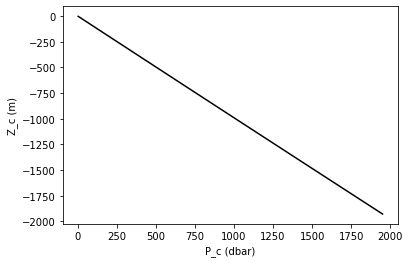

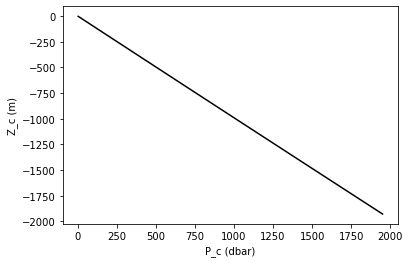

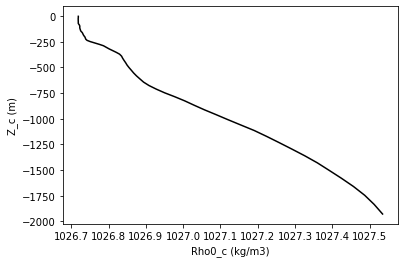

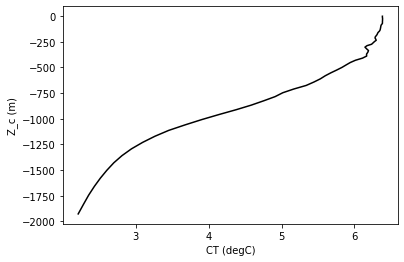

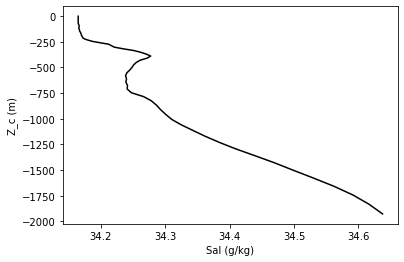

In [3]:
plt.figure()
plt.plot(P_c_2d[GOOD,:][0,:],
         Z_c_2d[GOOD,:][0,:],
         'k-'
        )
plt.ylabel('Z_c (m)')
plt.xlabel('P_c (dbar)')

plt.figure()
plt.plot(P_c_2d[GOOD,:][0,:],
         Z_c_2d[GOOD,:][0,:],
         'k-'
        )
plt.ylabel('Z_c (m)')
plt.xlabel('P_c (dbar)')

plt.figure()
plt.plot(Rho0_c_2d[GOOD,:][0,:],
         Z_c_2d[GOOD,:][0,:],
         'k-'
        )
plt.ylabel('Z_c (m)')
plt.xlabel('Rho0_c (kg/m3)')

plt.figure()
plt.plot(CT_c_2d[GOOD,:][0,:],
         Z_c_2d[GOOD,:][0,:],
         'k-'
        )
plt.ylabel('Z_c (m)')
plt.xlabel('CT (degC)')

plt.figure()
plt.plot(PSal_c_2d[GOOD,:][0,:],
         Z_c_2d[GOOD,:][0,:],
         'k-'
        )
plt.ylabel('Z_c (m)')
plt.xlabel('Sal (g/kg)')

/net/bgr/Python/Packages/OML_TST/oceanmixedlayers/pe_anomaly.py:19: RuntimeWarning: invalid value encountered in true_divide
  T_Mixed = np.sum((Tracer*dZ)[:nlev,...],axis=0)/DZ_Mixed
<ipython-input-11-3d8212b1ec1c>:145: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,)


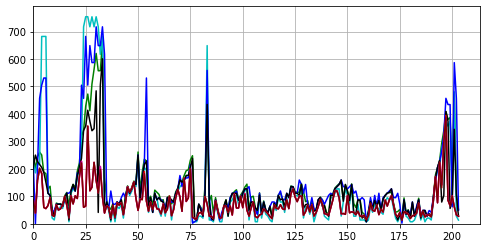

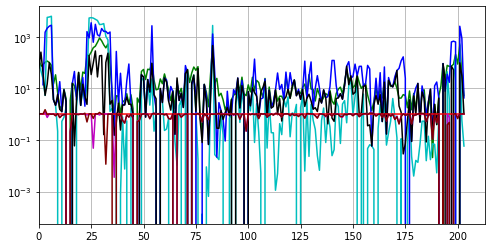

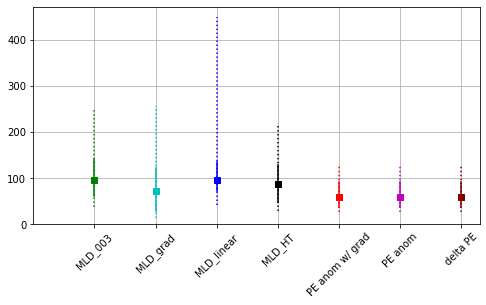

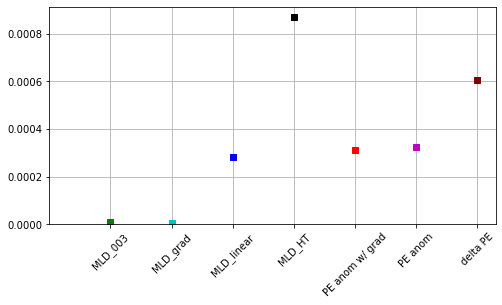

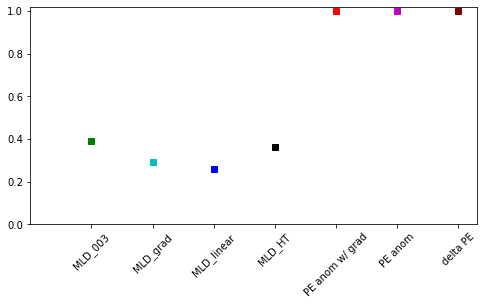

In [11]:
Timing = True

if Timing:
    import time

# Compute a series of MLDs using the threshold method:
if Timing: _=time.time()
MLD_003,MLD_003i = oceanmixedlayers.threshold(P_c_2d[GOOD,:].T,
                                              Rho0_c_2d[GOOD,:].T,
                                              delta=0.03,
                                              ref=10
                                             )  

# Compute a series of MLDs using the gradient method:
if Timing: a=time.time()
MLD_gradient,MLD_gradienti = oceanmixedlayers.gradient(P_c_2d[GOOD,:].T,
                                                       -Rho0_c_2d[GOOD,:].T,
                                                       critical_gradient=0.0005
                                                      )  

# Compute a series of MLDs using the linearfit method
if Timing: b=time.time()
MLD_linfit,MLD_linfiti = oceanmixedlayers.linearfit(P_c_2d[GOOD,:].T,
                                                    -Rho0_c_2d[GOOD,:].T,
                                                    error_tolerance=1.e-10)  

# Compute a series of MLDs using the Holte and Talley algorithm method
if Timing: c=time.time()
OUT = oceanmixedlayers.holtetalley(P_c_2d[GOOD,:].T,
                                 PSal_c_2d[GOOD,:].T,
                                 CT_c_2d[GOOD,:].T,
                                 Rho0_c_2d[GOOD,:].T)
MLD_ht=OUT[2]

# Compute a series of MLDs using the PE anomaly with a gradient in Rho0
if Timing: d=time.time()
MLD_pelin = oceanmixedlayers.mld_pe_anomaly(Z_c_2d[GOOD,:].T,
                                            dZ_2d[GOOD,:].T,
                                            Rho0_c_2d[GOOD,:].T,
                                            dRho0dz_c_2d[GOOD,:].T,
                                            energy=10.,
                                            gradient=True
                                           )

# Compute a series of MLDs using the PE anomaly asuming constant Rho0 over a layer
if Timing: e=time.time()
MLD_pe = oceanmixedlayers.mld_pe_anomaly(Z_c_2d[GOOD,:].T,
                                         dZ_2d[GOOD,:].T,
                                         Rho0_c_2d[GOOD,:].T,
                                         energy=10.,
                                         gradient=False
                                        )

# Compute a series of MLDs using the PE anomaly asuming constant Rho0 over a layer
if Timing: f=time.time()
MLD_delta = oceanmixedlayers.mld_delta_pe(P_c_2d[GOOD,:].T,
                                          dP_2d[GOOD,:].T,
                                          CT_c_2d[GOOD,:].T,
                                          PSal_c_2d[GOOD,:].T,
                                          energy=10.,
                                         )


if Timing: g=time.time()
    
# Compute the PE anomaly for the threshold MLD
e_MLD_003 = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                        dZ_2d[GOOD,:].T,
                                        Rho0_c_2d[GOOD,:].T,
                                        dRho0dz_c_2d[GOOD,:].T,
                                        depth=-MLD_003,
                                        gradient=True
                                       )
# Compute the PE anomaly for the gradient MLD
e_MLD_gradient = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                             dZ_2d[GOOD,:].T,
                                             Rho0_c_2d[GOOD,:].T,
                                             dRho0dz_c_2d[GOOD,:].T,
                                             depth=-MLD_gradient,
                                             gradient=True
                                            )
# Compute the PE anomaly for the linearfit MLD
e_MLD_linfit = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                           dZ_2d[GOOD,:].T,
                                           Rho0_c_2d[GOOD,:].T,
                                           dRho0dz_c_2d[GOOD,:].T,
                                           depth=-MLD_linfit,
                                           gradient=True
                                          )
# Compute the PE anomaly for the Holte and Talley MLD
e_MLD_ht = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                       dZ_2d[GOOD,:].T,
                                       Rho0_c_2d[GOOD,:].T,
                                       dRho0dz_c_2d[GOOD,:].T,
                                       depth=-MLD_ht,
                                       gradient=True
                                      )
# Compute the PE anomaly for the PE anomaly MLD (w/ gradient)
e_MLD_pelin = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                          dZ_2d[GOOD,:].T,
                                          Rho0_c_2d[GOOD,:].T,
                                          dRho0dz_c_2d[GOOD,:].T,
                                          depth=-MLD_pelin,
                                          gradient=True
                                         )
# Compute the PE anomaly for the PE anomaly MLD
e_MLD_pe = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                       dZ_2d[GOOD,:].T,
                                       Rho0_c_2d[GOOD,:].T,
                                       dRho0dz_c_2d[GOOD,:].T,
                                       depth=-MLD_pe,
                                       gradient=True
                                      )
# Compute the PE anomaly for the PE anomaly MLD
e_MLD_delta = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                          dZ_2d[GOOD,:].T,
                                          Rho0_c_2d[GOOD,:].T,
                                          dRho0dz_c_2d[GOOD,:].T,
                                          depth=-MLD_delta,
                                          gradient=True
                                         )


plt.figure(figsize=(8,4))
plt.plot(MLD_003,'g-')
plt.plot(MLD_gradient,'c-')
plt.plot(MLD_linfit,'b-')
plt.plot(MLD_ht,'k-')
plt.plot(MLD_pelin,'r-')
plt.plot(MLD_pe,'m-')
plt.plot(MLD_delta,'-',color='maroon')
plt.xlim(0,)
plt.ylim(0,)
plt.grid(True)

plt.figure(figsize=(8,4))
plt.semilogy(e_MLD_003,'g-')
plt.plot(e_MLD_gradient,'c-')
plt.plot(e_MLD_linfit,'b-')
plt.plot(e_MLD_ht,'k-')
plt.plot(e_MLD_pelin,'r-')
plt.plot(e_MLD_pe,'m-')
plt.plot(e_MLD_delta,'-',color='maroon')
plt.xlim(0,)
plt.ylim(0,)
plt.grid(True)

plt.figure(figsize=(8,4))
def boxwhisk(index,MLD,color='k'):
    plt.plot(index,np.median(MLD),'s',color=color)
    plt.plot([index,index],[np.percentile(MLD,10),np.percentile(MLD,90)],':',color=color)
    plt.plot([index,index],[np.percentile(MLD,25),np.percentile(MLD,75)],'-',color=color)
boxwhisk(1,MLD_003,color='g')
boxwhisk(2,MLD_gradient,color='c')
boxwhisk(3,MLD_linfit,color='b')
boxwhisk(4,MLD_ht,color='k')
boxwhisk(5,MLD_pelin,color='r')
boxwhisk(6,MLD_pe,color='m')
boxwhisk(7,MLD_delta,color='maroon')
plt.xlim(0,)
plt.ylim(0,)
plt.grid(True)
plt.xticks([1,2,3,4,5,6,7],['MLD_003','MLD_grad','MLD_linear','MLD_HT','PE anom w/ grad','PE anom', 'delta PE'],rotation=45)

if Timing: 
    plt.figure(figsize=(8,4))
    plt.plot(1,(a-_)/np.sum(GOOD),'gs')
    plt.plot(2,(b-a)/np.sum(GOOD),'cs')
    plt.plot(3,(c-b)/np.sum(GOOD),'bs')
    plt.plot(4,(d-c)/np.sum(GOOD),'ks')
    plt.plot(5,(e-d)/np.sum(GOOD),'rs')
    plt.plot(6,(f-e)/np.sum(GOOD),'ms')
    plt.plot(7,(g-f)/np.sum(GOOD),'s',color='maroon')
    plt.xlim(0,)
    plt.ylim(0,)
    plt.grid(True)
plt.xticks([1,2,3,4,5,6,7],['MLD_003','MLD_grad','MLD_linear','MLD_HT','PE anom w/ grad','PE anom', 'delta PE'],rotation=45)

plt.figure(figsize=(8,4))
plt.plot(1,np.corrcoef(MLD_pelin,MLD_003)[1,0]**2,'gs')
plt.plot(2,np.corrcoef(MLD_pelin,MLD_gradient)[1,0]**2,'cs')
plt.plot(3,np.corrcoef(MLD_pelin,MLD_linfit)[1,0]**2,'bs')
plt.plot(4,np.corrcoef(MLD_pelin,MLD_ht)[1,0]**2,'ks')
plt.plot(5,np.corrcoef(MLD_pelin,MLD_pelin)[1,0]**2,'rs')
plt.plot(6,np.corrcoef(MLD_pelin,MLD_pe)[1,0]**2,'ms')
plt.plot(7,np.corrcoef(MLD_pelin,MLD_delta)[1,0]**2,'s',color='maroon')
plt.ylim(0.,1.02)
plt.xlim(0,)
plt.xticks([1,2,3,4,5,6,7],['MLD_003','MLD_grad','MLD_linear','MLD_HT','PE anom w/ grad','PE anom', 'delta PE'],rotation=45)

pass;

Text(0, 0.5, 'delta PE')

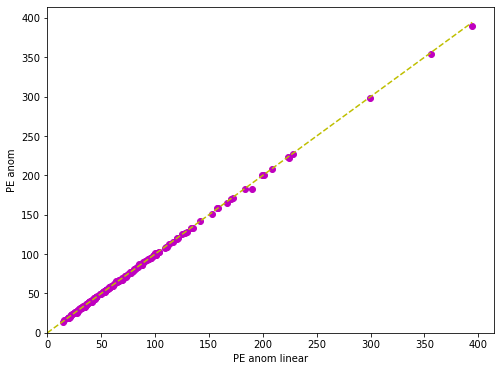

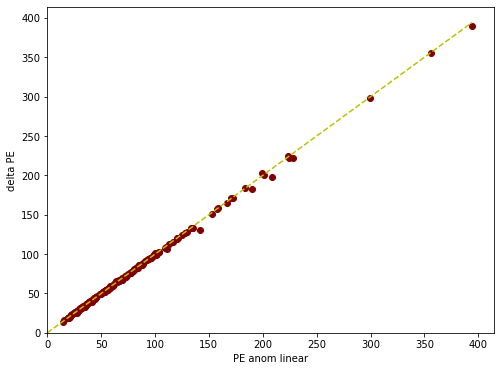

In [12]:
plt.figure(figsize=(8,6))
plt.plot(MLD_pelin,MLD_pe,'mo')
plt.plot([0,max(MLD_pelin)],[0,max(MLD_pelin)],
        'y--')
plt.xlim(0,max(MLD_pelin)+20)
plt.ylim(0,max(MLD_pelin)+20)
plt.xlabel('PE anom linear')
plt.ylabel('PE anom')

plt.figure(figsize=(8,6))
plt.plot(MLD_pelin,MLD_delta,'o',color='maroon')
plt.plot([0,max(MLD_pelin)],[0,max(MLD_pelin)],
        'y--')
plt.xlim(0,max(MLD_pelin)+20)
plt.ylim(0,max(MLD_pelin)+20)
plt.xlabel('PE anom linear')
plt.ylabel('delta PE')


(-3.0, 3.0)

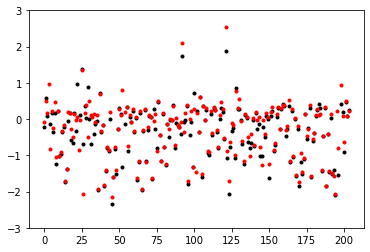

In [14]:
plt.plot(MLD_delta-MLD_pelin,'k.')
plt.plot(MLD_pe-MLD_pelin,'r.')
plt.ylim(-3,3)